# Assignment - Style Transfer

*AI VIET NAM* 

- Bạn cần hoàn thành các phần trong dấu:
```python
########### YOUR CODE HERE #################
###########################################
```

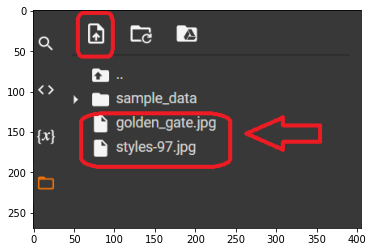

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("https://www.dropbox.com/s/8hhb4flk8e7p89i/img1.png?dl=1")
imgplot = plt.imshow(img)

# Phần 2:

Trong phần này chúng ta sẽ xây dựng 2 hàm correlation là Gram matrix và Pearsonr correlation, các correlation khác sẽ tìm hiểu sau

In [ ]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os
import copy
from scipy.ndimage import rotate

In [ ]:
# Hyperparams
total_variation_weight = 30
style_weight=1e-2
content_weight=1e4
img_size = (422, 512)  #(H, W)

## Code các hàm xử lí ảnh đầu vào

In [ ]:
content_path = "/content/golden_gate.jpg"
style_path = "/content/styles-97.jpg"

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img, img_size):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, img_size)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 422, 512, 3)
(1, 422, 512, 3)


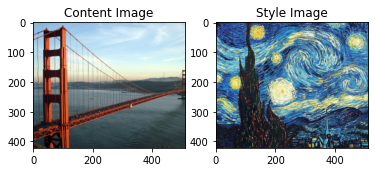

In [ ]:
content_image = load_img(content_path, img_size)
style_image = load_img(style_path, img_size)

print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Tiến hành load model pretrain VGG19 từ Tensorflow

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
content_layers = ['block5_conv2']
style_layers   = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model   = tf.keras.Model([vgg.input], outputs)
  return model

## Xây dựng hàm tính Gram matrix để lấy thông tin từ ảnh style

Mạng VGG19 sẽ biến ảnh $x_{0} \in \mathcal{R}^{W_{0} \times H_{0} \times 3}$ thành tập các feature map $\{F^l(x_{0}\}^L_{l=1}$, trong đó $F^l : \mathcal{R}^{W_{0} \times H_{0} \times 3} \rightarrow \mathcal{R}^{W_{l} \times H_{l} \times D_{l}}$. Thông tin style được tính bằng Gram matrix của feature map $F_{l}$ thuộc layer $l$.

Công thức tính Gram matrix:
$$[G^l(F^l)]_{ij} = \sum\limits_{k}^{} F^l_{ik}F^l_{jk}$$



In [ ]:
def gram_matrix(input_tensor):
  ########### YOUR CODE HERE ################
  
  ###########################################

## Xây dựng hàm tính Pearsonr correlation để lấy thông tin từ ảnh style

Pearsonr correlation $\rho^l_{ij}$ giữa feature map thứ $i^{th}$ và feature map thứ $j^{th}$ trong layer $l$ được dùng để lấy thông tin style.

Công thức tính Pearsonr correlation:
$${\rho^l_{i,j}} = \frac{{\mathbb{E}\left[ {(F_i^l) - \overline {F_i^l} )(F_j^l - \overline {F_j^l} )} \right]}}{{\sigma _i^l\sigma _j^l}}$$

In [ ]:
def pearsonr_matrix(input_tensor):
    ########### YOUR CODE HERE ################
  
    ###########################################
    pass

## Xây dựng model để thực hiện feature extraction

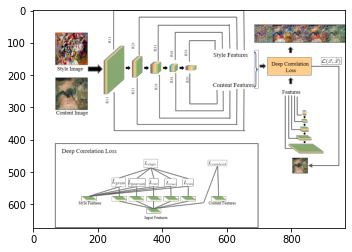

In [3]:
img1 = mpimg.imread("https://www.dropbox.com/s/zqropnnafu25f5f/img4.png?dl=1")
imgplot = plt.imshow(img1)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}

In [ ]:
class StyleContentModel_style(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel_style, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs_1 = [gram_matrix(style_output)
                        for style_output in style_outputs]

        style_outputs_2 = [pearsonr_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = ########### YOUR CODE HERE ################
  
                        ###########################################

        style_dict_1 = ########### YOUR CODE HERE ################
  
                        ###########################################

        style_dict_2 = ########### YOUR CODE HERE ################
  
                        ###########################################
        
        return {'content':content_dict, 'style_1':style_dict_1, 'style_2':style_dict_2}

In [ ]:
extractor_style = StyleContentModel_style(style_layers, content_layers)
extractor       = StyleContentModel(style_layers, content_layers)

In [ ]:
style_targets_1 = extractor_style(style_image)['style_1']
style_targets_2 = extractor_style(style_image)['style_2']
content_targets = extractor(content_image)['content']

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

## Tổng hợp Content loss và Style loss

Hàm loss tổng hợp có dạng:
$${L_{style}} = \frac{1}{2}(L_{gram} + {L_{pearson}} )$$

In [ ]:
def style_content_loss_1(outputs):
    '''Hàm loss tính với Gram matrix'''
    ########### YOUR CODE HERE ################
  
    ###########################################

def style_content_loss_2(outputs):
    '''Hàm loss tính với Pearsonr correlation'''
    ########### YOUR CODE HERE ################
  
    ###########################################

In [ ]:
@tf.function()
def train_step(image_1, image_2):
    with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2:
        outputs_1 = extractor(image_1)
        outputs_2 = extractor(image_2)

        loss_1 = style_content_loss_1(outputs_1)
        loss_2 = style_content_loss_2(outputs_2)

        loss_1 += total_variation_weight*tf.image.total_variation(image_1)
        loss_2 += total_variation_weight*tf.image.total_variation(image_2)

        loss = (loss_1 + loss_2) / 2

    grad_1 = tape_1.gradient(loss, image_1)
    grad_2 = tape_2.gradient(loss, image_2)

    opt.apply_gradients([(grad_1, image_1)])
    opt.apply_gradients([(grad_2, image_2)])

    image_1.assign(clip_0_1(image_1))
    image_2.assign(clip_0_1(image_2))

In [ ]:
opt = tf.optimizers.Adam(0.02, beta_1=0.99, epsilon=0.1)

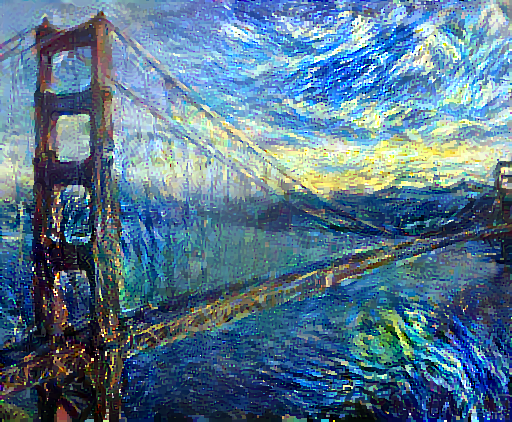

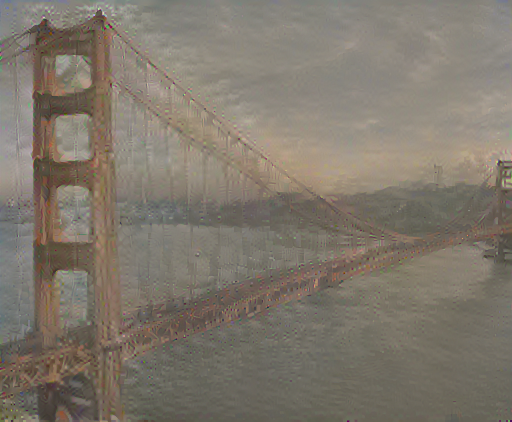

Train step: 3000
Total time: 231.2


In [ ]:
image_1 = tf.Variable(content_image)
image_2 = tf.Variable(content_image)

import time
start = time.time()

epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image_1, image_2)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_1))
  display.display(tensor_to_image(image_2))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))